In [ ]:
'''
        ***** Image Classification with TensorFlow for Cat/Dog Use case********

In this notebook, 
A. Used local data of Cat/Dog image to build Image classification model using TensorFlow library (CNN)
B. For referencing Image data, there are different ways of providing a reference of Image data such as 
    a. via 'flow_from_directory' api  - This is used when you have two different folder for Train and Validation images
    b. via 'flow_from_dataframe' api - This is used when u have single folder and u load the images into dataframe and then split
        into Train and Validation image

C. In this notebook implementation, 
    a. 'flow_from_dataframe' api is used to load the data from local directory and used it in model fitting
    b. For model testing, Test Images are also been referenced via 'flow_from_dataframe' api and then performed prediction
    
C. Save the model and model weight into file and used these files for further prediction on Test Images
   
'''

In [2]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [11]:
# Part 1 -  Define the Image properties

print(os.listdir("."))

FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

['.ipynb_checkpoints', 'cat_dog_classifier.model', 'cat_dog_classifier_1.model', 'cat_dog_image_classification_local_data.ipynb', 'cat_dog_image_classification_online_data.ipynb', 'classifier.model1', 'classifier.model2', 'fashion_mist_classifier.model', 'imgClass.ipynb', 'minst_imgClass2.ipynb', 'sub-test-image', 'sub-test-image.zip', 'sub-train-image', 'sub-train-image.zip', 'test-subset', 'test-subset.zip']


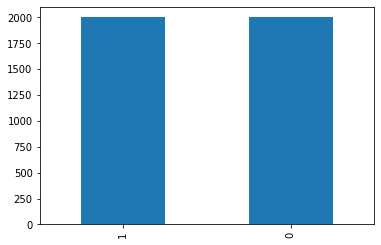

In [4]:
# Part 2 - Iterate over the local dir and save information into dataframe and then split into Train and Test image  

filenames = os.listdir("sub-train-image")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df['category'].value_counts().plot.bar()

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [15]:
# Part 3 - Create Image Data Generator for Train and validation set which will be used in model building

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

train_datagen =ImageDataGenerator(rescale=1./255) 
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "sub-train-image", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "sub-train-image", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3201 validated image filenames belonging to 2 classes.
Found 801 validated image filenames belonging to 2 classes.


In [12]:
# Part 4 - Initialising the CNN and compiling the model

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
__

In [17]:
# Part-5 Fitting the CNN to the images. Train the Model on Training images. For validation, used Test Images

epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)


Epoch 1/50
213/213 [==============================] - 150s 706ms/step - loss: 1.1089 - acc: 0.5807 - val_loss: 1.0641 - val_acc: 0.5535
Epoch 2/50
213/213 [==============================] - 146s 684ms/step - loss: 0.7353 - acc: 0.6519 - val_loss: 0.9123 - val_acc: 0.5811
Epoch 3/50
213/213 [==============================] - 146s 685ms/step - loss: 0.6048 - acc: 0.7046 - val_loss: 0.7375 - val_acc: 0.6453
Epoch 4/50
213/213 [==============================] - 153s 718ms/step - loss: 0.5430 - acc: 0.7338 - val_loss: 0.6065 - val_acc: 0.6868
Epoch 5/50
213/213 [==============================] - 146s 684ms/step - loss: 0.4921 - acc: 0.7633 - val_loss: 0.7448 - val_acc: 0.6792
Epoch 6/50
213/213 [==============================] - 148s 693ms/step - loss: 0.4165 - acc: 0.8095 - val_loss: 0.5992 - val_acc: 0.7233
Epoch 7/50
213/213 [==============================] - 149s 699ms/step - loss: 0.3826 - acc: 0.8368 - val_loss: 0.6008 - val_acc: 0.7522
Epoch 8/50
213/213 [============================

In [18]:
# Part 6- save model file and model weights 
model.save("Image_classifier_model_flow_from_dataframe.model1")
model.save_weights("Image_classifier_weight_flow_from_dataframe.model2")

In [19]:
# Part 7- Model prediction for all Test Images 

test_filenames = os.listdir("sub-test-image")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "sub-test-image", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

print(predict)

test_df['category'] = np.argmax(predict, axis=-1)
print(test_df.head())

Found 50 validated image filenames.
[[4.56376048e-03 9.95436251e-01]
 [9.99999762e-01 1.79998807e-07]
 [1.00000000e+00 1.17363487e-17]
 [9.80597913e-01 1.94020662e-02]
 [9.93660629e-01 6.33935072e-03]
 [4.32357550e-01 5.67642450e-01]
 [1.70151606e-01 8.29848409e-01]
 [9.99999881e-01 1.62513999e-07]
 [3.55463773e-01 6.44536197e-01]
 [8.28878395e-03 9.91711259e-01]
 [8.15482616e-01 1.84517354e-01]
 [1.00295036e-03 9.98997033e-01]
 [9.90251899e-01 9.74804536e-03]
 [5.40755536e-07 9.99999404e-01]
 [9.43154633e-01 5.68453372e-02]
 [9.72189128e-01 2.78108828e-02]
 [7.23135832e-04 9.99276936e-01]
 [4.03685272e-01 5.96314728e-01]
 [2.65801791e-03 9.97342050e-01]
 [9.84277368e-01 1.57227144e-02]
 [1.00000000e+00 5.56634079e-11]
 [9.95032191e-01 4.96782828e-03]
 [9.99999881e-01 6.31469774e-08]
 [6.17040992e-01 3.82959008e-01]
 [2.23129373e-08 1.00000000e+00]
 [9.88474190e-01 1.15258414e-02]
 [7.01669790e-03 9.92983341e-01]
 [9.92819488e-01 7.18047749e-03]
 [9.99889851e-01 1.10170855e-04]
 [9.987

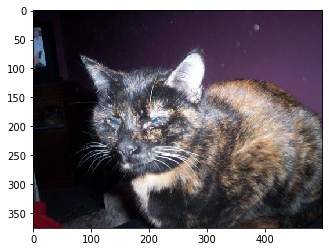

In [25]:
# Part 8- Validate model prediction for '13.jpg' 

sample='13.jpg'
image = load_img("sub-test-image/"+sample)
plt.imshow(image)

cat.1806.jpg


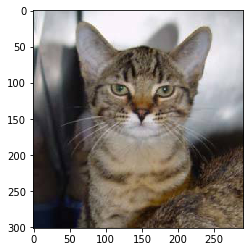

In [6]:
sample = random.choice(filenames)
print(sample)
image = load_img("sub-train-image/"+sample)
plt.imshow(image)